# SCC-ICMC-USP - 1o. semestre de 2024

## SCC5871/MAI5025 - Exercício 1

## Profa. Roseli A. F. Romero


Nro do grupo: - 

Alunos:

1.   João Francisco Baiochi (n.ºUSP 7547674)
2.   

---  

## Instruções  
  
A partir da base de dados do Kaggle, ```abalone.dat```, aplicar os 3 tipos de regressão:

- Regressão Linear
- Regressão Polinomial de grau 2
- regressão Lasso
- regressão RIDGE
  
Comparar as três métricas: MSE, MAE e R2 para cada tipo de regressão.

Dataset source: [Kaggle](https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset)  
Notebook source: [GitHub](https://github.com/baiochi/SCC5871_Ver6_Turma3_2024)

# Table of contents

1. [Exploratory Data Analysis](#exploratory-data-analysis)
   1. [Numerical features](#numerical-features)
   2. [Categorical features](#categorical-features)
   3. [Target](#target-feature)
2. [Modeling](#modeling)
   1. [Linear Regression](#linear-regression)
   2. [Polynomial Regression](#polynomial-regression)
   3. [Lasso regularization](#lasso-regularization)
   4. [RIDGE regularization](#ridge-regularization)
   5. [Optimizing the model](#optimizing-the-model)
3. [Conclusions](#conclusions)


In [1]:
import warnings
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib
import seaborn as sns
import session_info
from src.utils import (numerical_plot, categorical_plot, plot_heatmap,
                       get_metrics, get_feature_importance,
                       plot_regression_results, metrics_report)

# Supress warnings
warnings.filterwarnings("ignore")

# Set grid style
sns.set(style="darkgrid")

session_info.show(excludes=['src'], dependencies=False)

# 1. Análise Exploratória dos Dados

In [2]:
# Load Abalon dataset
df = pd.read_csv('../data/abalone.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Define target and features
target = 'Rings'
features = df.drop(columns=target).columns.tolist()

## 1.1. Features numéricas

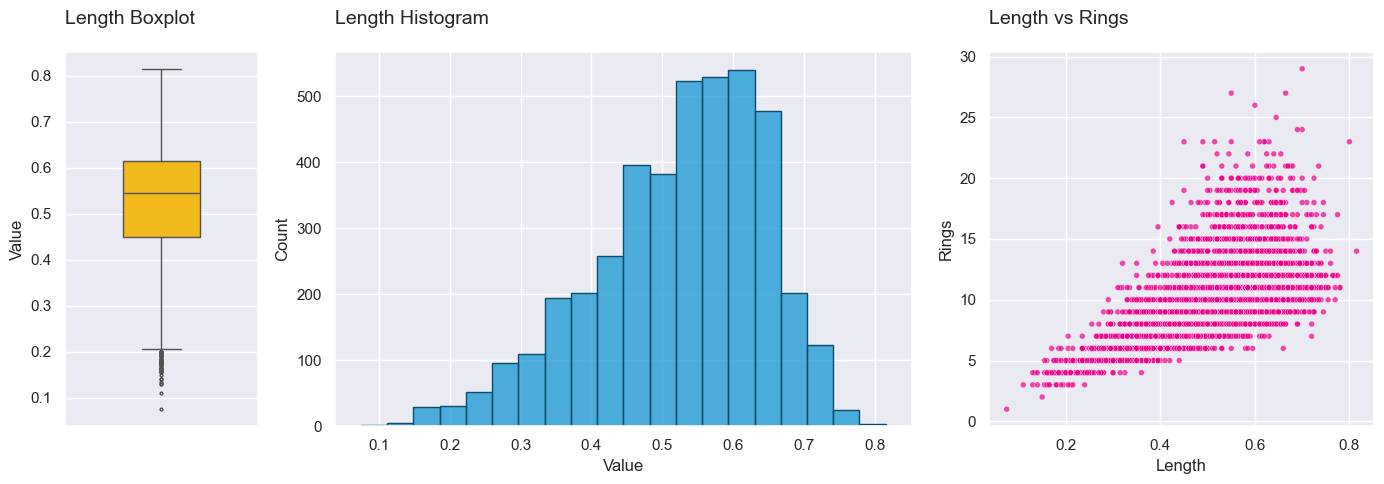

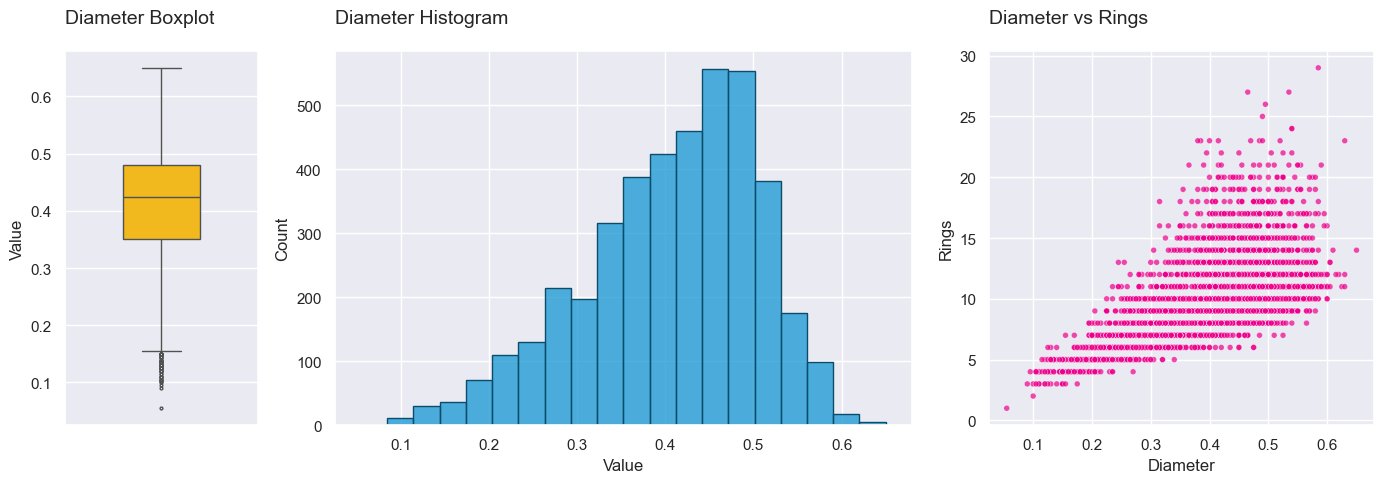

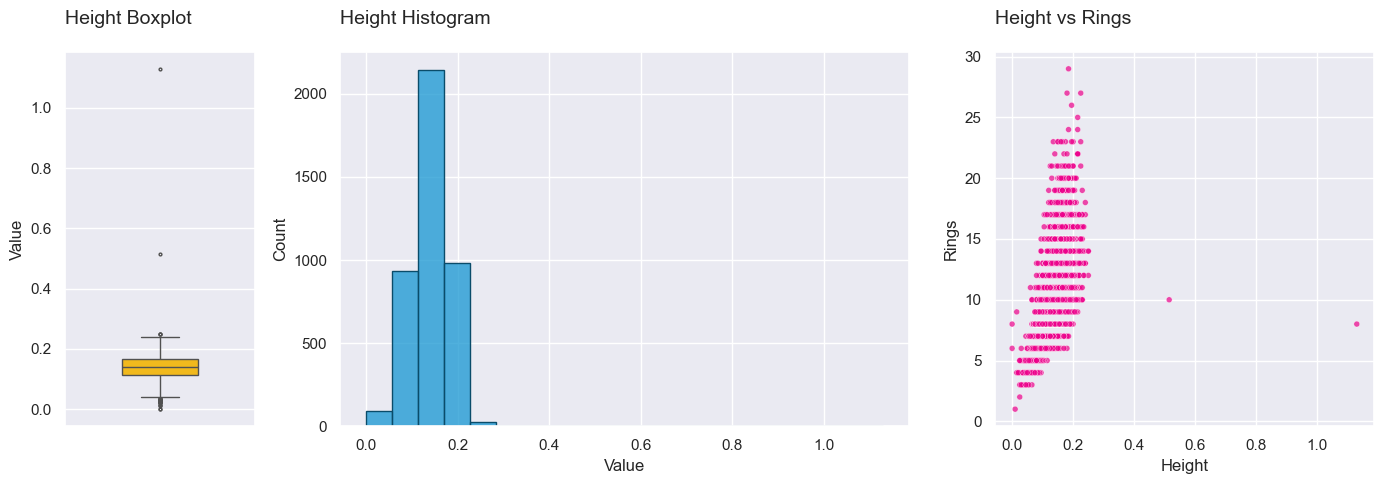

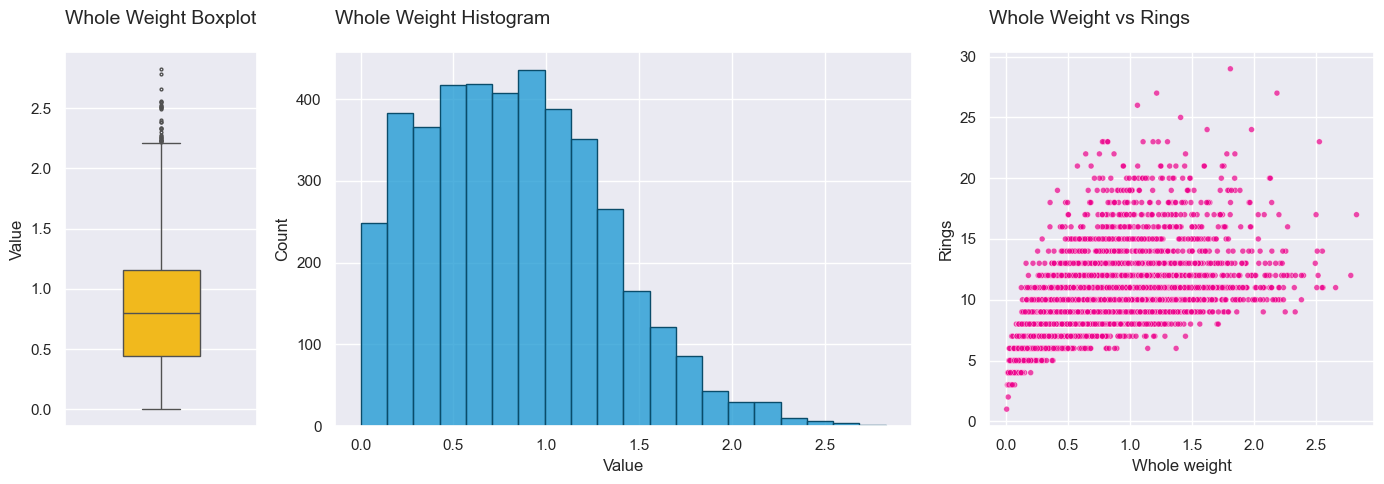

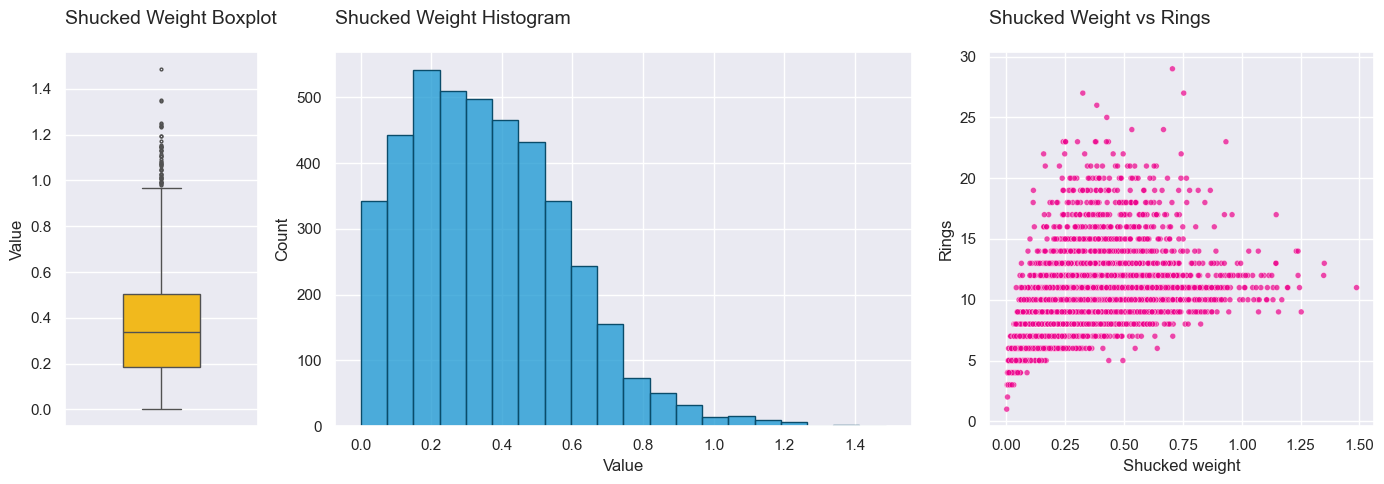

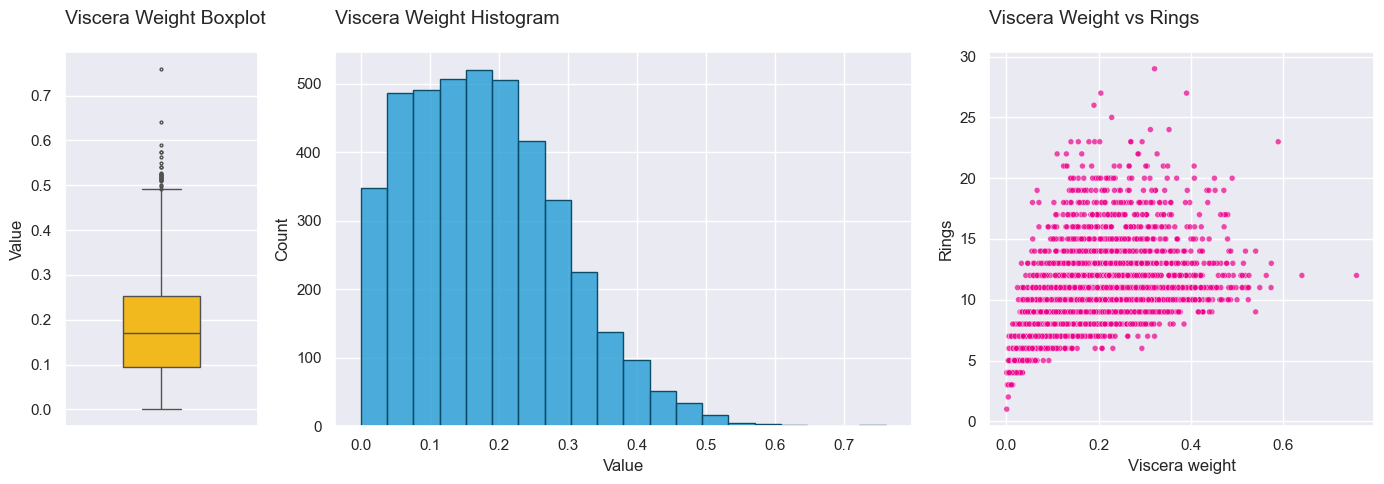

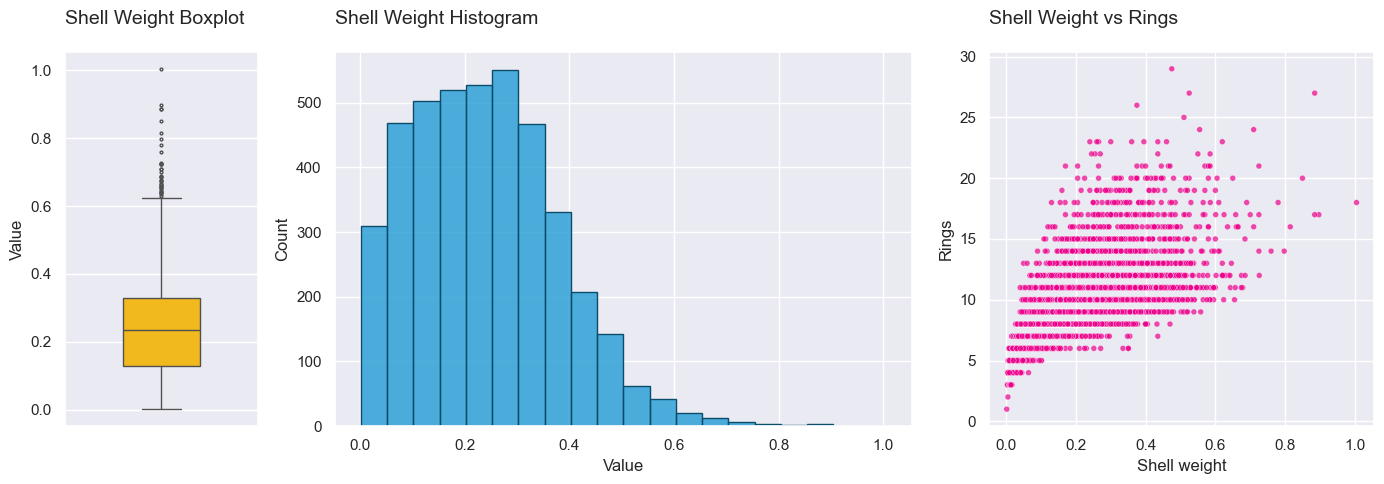

In [4]:
for col in df.select_dtypes(include='float64').columns:
    numerical_plot(df, col, target)

## 1.2. Features categóricas

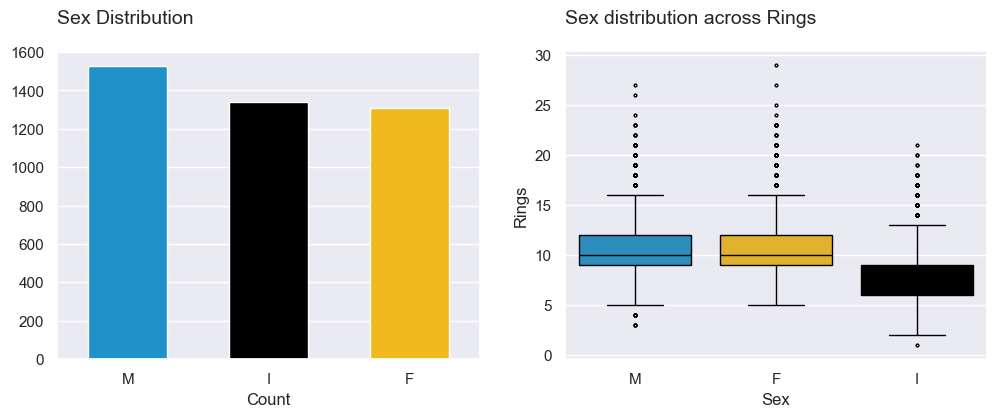

In [5]:
for col in df.select_dtypes(include='object').columns:
    categorical_plot(df, col, target)

## 1.3. Distribuição do target

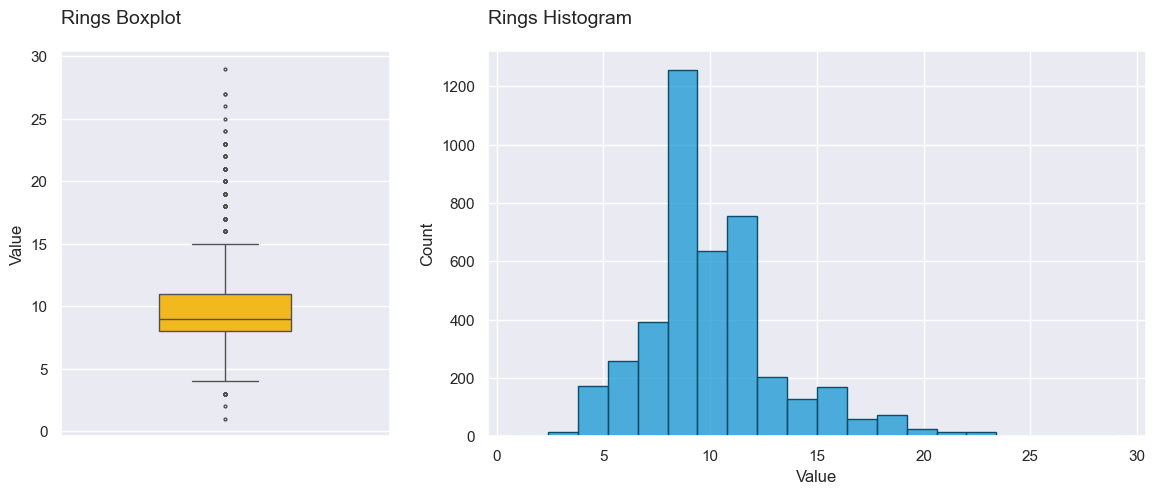

In [6]:
numerical_plot(df, target)

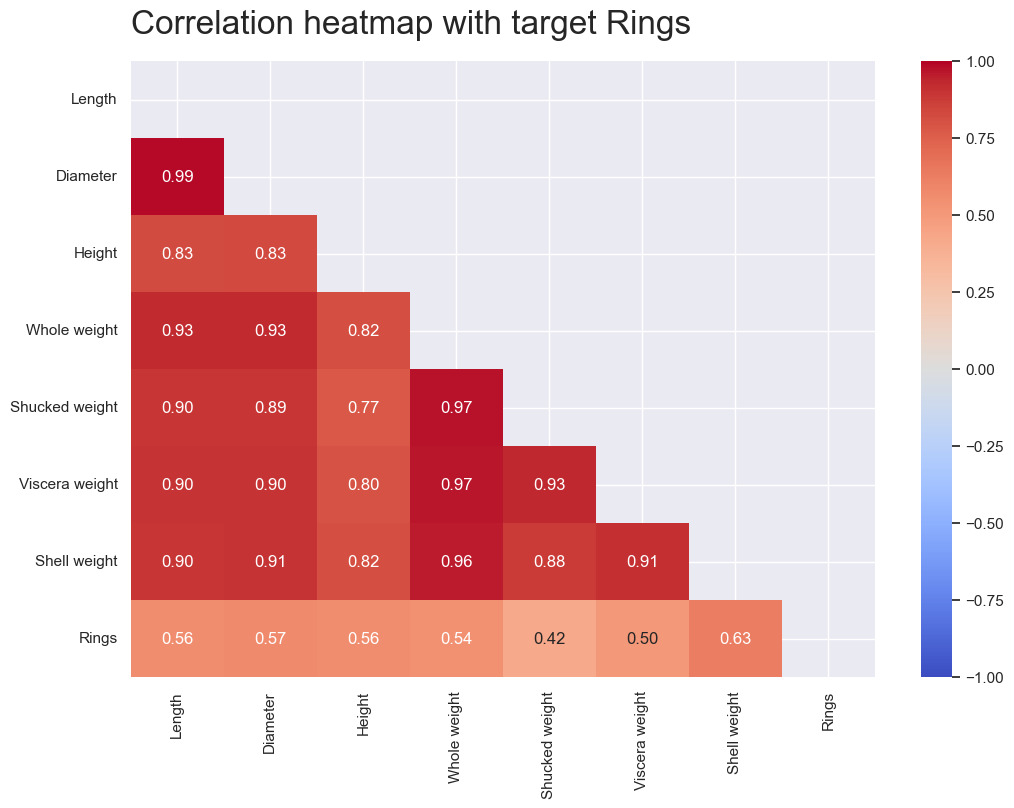

In [7]:
plot_heatmap(df, target)

# 2. Modelagem

Nesta seção da modelagem, vamos preparando os dados para o treinamento do modelo. As seguintes etapas serão realizadas:

1. Definição do alvo e das características: primeiro, definimos a variável alvo (y) e as features (X). A variável alvo é o que queremos prever, enquanto as características são os dados que usaremos para fazer essa previsão.  

2. Divisão dos dados: Em seguida, dividimos nossos dados em conjuntos de treinamento e teste usando a função ``train_test_split`` do sklearn. Isso nos permite treinar nosso modelo em um conjunto de dados e depois testá-lo em um conjunto de dados separado que o modelo nunca viu antes. Neste caso, estamos usando 80% dos dados para treinamento e 20% para teste.  
3. Construção do pipeline de pré-processamento: aqui, estamos construindo um pipeline de pré-processamento para preparar nossos dados para o modelo. Este pipeline trata separadamente das características numéricas e categóricas:  
    - Para as características numéricas, estamos aplicando um ``StandardScaler``, que padroniza as características subtraindo a média e, em seguida, escalonando para a unidade de variância.  
    - Para as características categóricas, estamos aplicando um ``OneHotEncoder``, que converte variáveis categóricas em uma forma que pode ser fornecida aos algoritmos de Machine Learning.  

Para avaliar o desempenho de cada modelo, vamos analisar as seguintes métricas de avaliação:
- **MAE**: mais simples de entender, mas ela penaliza mais erros menores;
- **MSE**: mais comum, pois essa métrica penaliza mais os erros maiores, o que faz mais sentido em aplicações reais.
- **RMSE**: mais popular, pois esta métrica está nas mesmas unidades que o target.
- **R2**: tem variação de 0 a 1, onde 1 é o melhor valor. Ela é uma métrica que mede a proporção da variância do target explicada pelo modelo.  

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define target and features
X = df.drop(columns=target).copy()
y = df[target].copy()

test_size = .2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state)

# Build Preprocessing pipeline
numerical_features = X.select_dtypes(include='float64').columns
categorical_features = X.select_dtypes(include='object').columns

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])

## 2.1. Regressão Linear

Linear Regression metrics:


,Train,Test
MAE,1.576428,1.593107
MSE,4.783854,4.891232
RMSE,2.187202,2.211613
R2,0.534824,0.548163
R2_CV,0.418602,0.418602
RMSE_CV,2.241679,2.241679


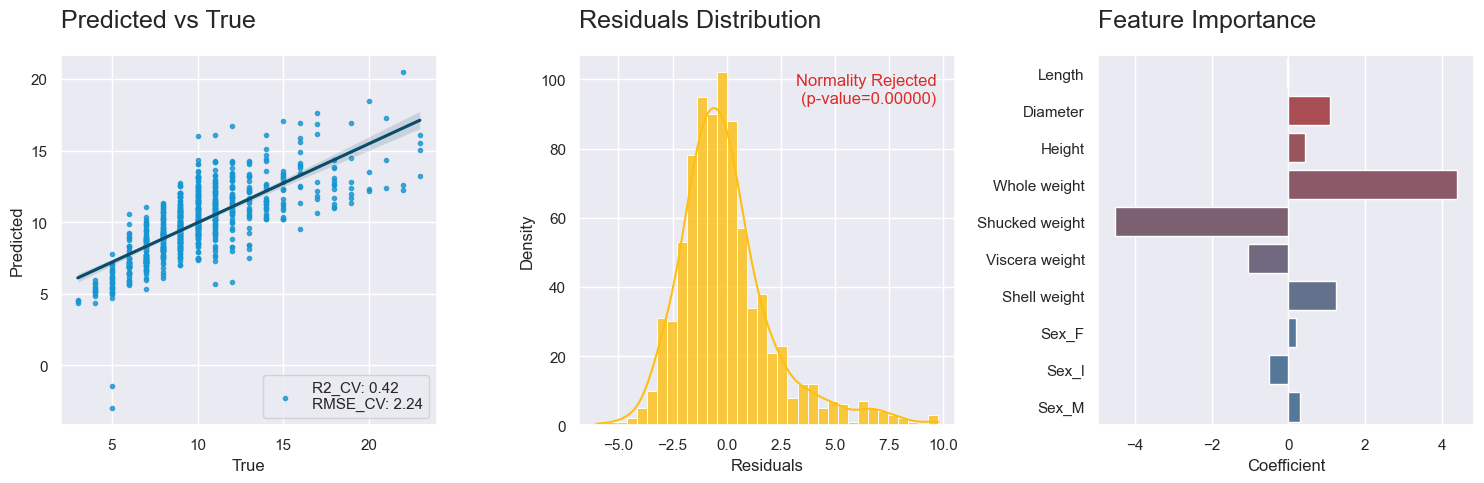

In [9]:
from sklearn.linear_model import LinearRegression

# Model Pipeline
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Fit model
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Display metrics
lr_metrics = get_metrics(lr_model, X, y, cv=True)
print('Linear Regression metrics:')
display(lr_metrics)
lr_feature_importance = get_feature_importance(lr_model)
plot_regression_results(y_test, y_pred,
                        lr_metrics.loc[['R2_CV', 'RMSE_CV'], 'Test'].values,
                        lr_feature_importance)

Este modelo serve como nossa base para comparar e avaliar o desempenho de modelos mais sofisticados. A Regressão Linear, sendo um modelo simples, pressupõe uma relação linear entre as características (features) e a variável alvo (target). No entanto, observamos que, além de apresentar um score relativamente baixo, a distribuição dos resíduos não é uniforme. Isso sugere que o modelo não está sendo eficaz em capturar a relação existente entre as características e a variável alvo.

## 2.2. Regressão Polinomial

Em seguida, usaremos a classe `PolynomialFeatures` para criar novas características que são combinações polinomiais das características existentes. Este método aumenta a complexidade do modelo, possibilitando a captura de relações não lineares entre as características e a variável alvo.  

No entanto, é crucial lembrar que a adição de inúmeros características polinomiais pode resultar em overfitting. Isso ocorre quando o modelo se torna excessivamente complexo e começa a capturar o ruído presente nos dados de treinamento, em vez de aprender a verdadeira relação subjacente. Para evitar isso, é recomendável utilizar a validação cruzada para determinar o grau polinomial que proporciona o melhor desempenho do modelo, equilibrando a complexidade e a capacidade de generalização.

Polynomial Regression metrics:
Degree 2: R2=0.29, RMSE=2.47
Degree 3: R2=-0.01, RMSE=2.65
Degree 4: R2=-2007.57, RMSE=84.52
Best Polynomial Regression metrics (degree=2):


,Train,Test
MAE,1.465322,1.538465
MSE,4.191283,4.829969
RMSE,2.047262,2.197719
R2,0.592445,0.553822
R2_CV,0.292676,0.292676
RMSE_CV,2.473574,2.473574


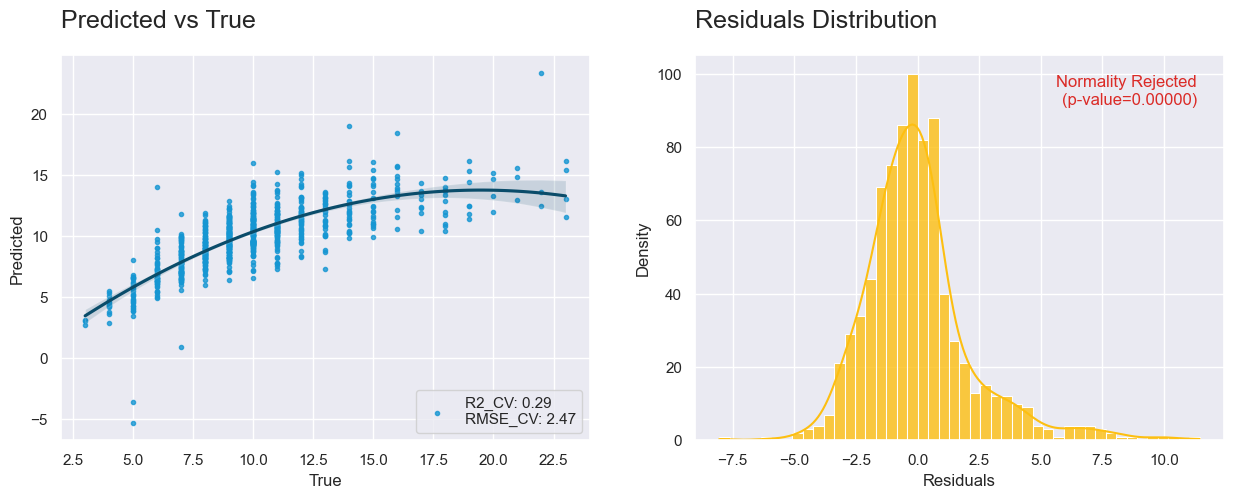

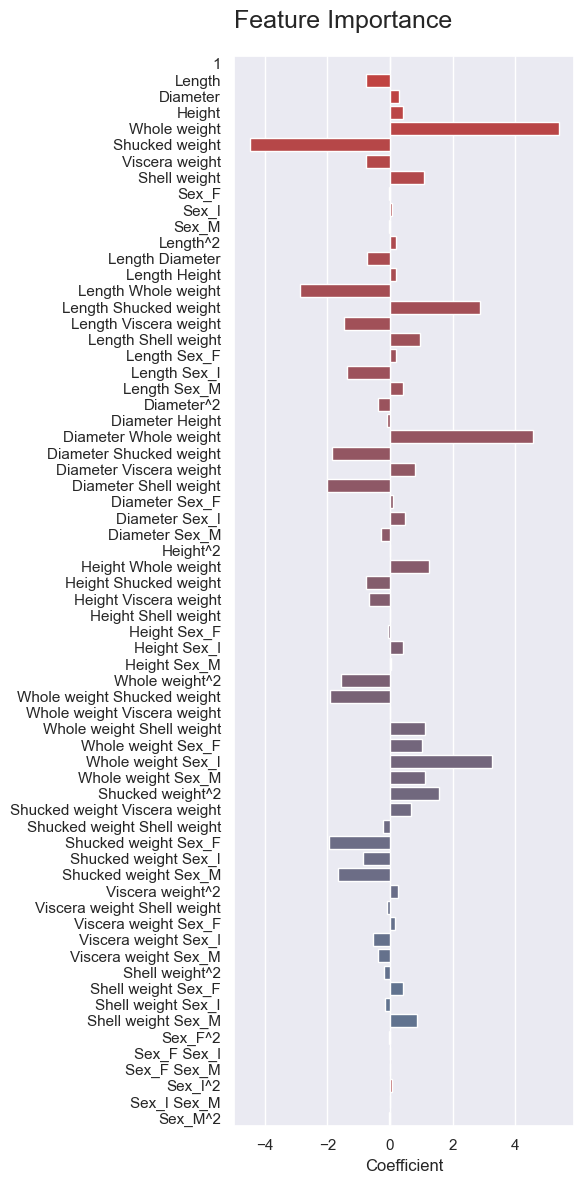

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly_metrics = {}
for degree in [2, 3, 4]:
    poly_model = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', LinearRegression())
    ])
    
    # Fit model
    poly_model.fit(X_train, y_train)
    _metrics = get_metrics(poly_model, X, y, cv=True)
    poly_metrics[degree] = {
        'R2': _metrics.loc['R2_CV', 'Test'],
        'RMSE': _metrics.loc['RMSE_CV', 'Test']
    }
    
print('Polynomial Regression metrics:')
for degree, metrics in poly_metrics.items():
    print(f'Degree {degree}: R2={metrics["R2"]:.2f}, RMSE={metrics["RMSE"]:.2f}')
    

# Run best model
best_degree = max(poly_metrics, key=lambda x: poly_metrics[x]['R2'])
poly_model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('model', LinearRegression())
]).fit(X_train, y_train)

# Predict
y_pred = poly_model.predict(X_test)

# Display metrics
poly_metrics = get_metrics(poly_model, X, y, cv=True)
print(f'Best Polynomial Regression metrics (degree={best_degree}):')
display(poly_metrics)
poly_feature_importance = get_feature_importance(poly_model)
plot_regression_results(y_test, y_pred,
                        poly_metrics.loc[['R2_CV', 'RMSE_CV'], 'Test'].values,
                        poly_feature_importance,
                        order=best_degree)

As métricas revelam que, dentre os modelos de regressão polinomial testados, o de segundo grau apresentou um desempenho superior aos de terceiro e quarto graus. No entanto, mesmo o modelo de segundo grau não conseguiu superar o desempenho do modelo de regressão linear anteriormente aplicado. Tanto o coeficiente de determinação (R2), quanto o erro quadrático médio da raiz (RMSE), embora maior do que para os outros graus polinomiais, ainda é inferior ao obtido pelo modelo linear. 
  
Para os modelos de terceiro e quarto graus, as métricas indicam um desempenho ainda mais insatisfatório. O R2 negativo para os graus 3 e 4 sugere que esses modelos se ajustaram menos eficientemente aos dados do que um modelo horizontal simples. Ademais, o RMSE elevado para o grau 4 revela que as previsões deste modelo divergem significativamente dos valores reais.   

Esses resultados indicam que a inclusão de características polinomiais de grau superior não aprimorou o desempenho do modelo. Também podemos descartar a ocorrência de overfitting, uma situação em que o modelo se torna excessivamente complexo e começa a capturar o ruído nos dados, pois as métricas de treino e teste apresentaram valores muito próximos.

## 2.3. Lasso (L1)

A regularização Lasso (Least Absolute Shrinkage and Selection Operator) é uma técnica de regularização usada em modelos de aprendizado de máquina e estatística para prevenir o overfitting e melhorar a interpretabilidade do modelo.   

A regularização Lasso adiciona uma penalidade ao termo de erro do modelo que é proporcional ao valor absoluto dos coeficientes do modelo. Esta penalidade tem o efeito de encolher alguns dos coeficientes para zero, o que é equivalente a eliminar a característica correspondente do modelo. Isso pode ser útil quando você tem inúmeras características e acredita que apenas algumas delas são realmente importantes.   

A força da penalidade Lasso é controlada por um hiperparâmetro, geralmente denotado por λ (lambda). Quando λ é zero, a regularização Lasso é equivalente a uma regressão linear comum. À medida que λ aumenta, a penalidade de regularização se fortalece e mais coeficientes são encolhidos para zero. Se λ for muito grande, todos os coeficientes podem ser encolhidos para zero, resultando em um modelo que é muito simples e subajustado.

Lasso Regression metrics:


,Train,Test
MAE,1.960956,2.008147
MSE,7.253832,7.693870
RMSE,2.693294,2.773783
R2,0.294647,0.289264
R2_CV,0.157448,0.157448
RMSE_CV,2.719329,2.719329


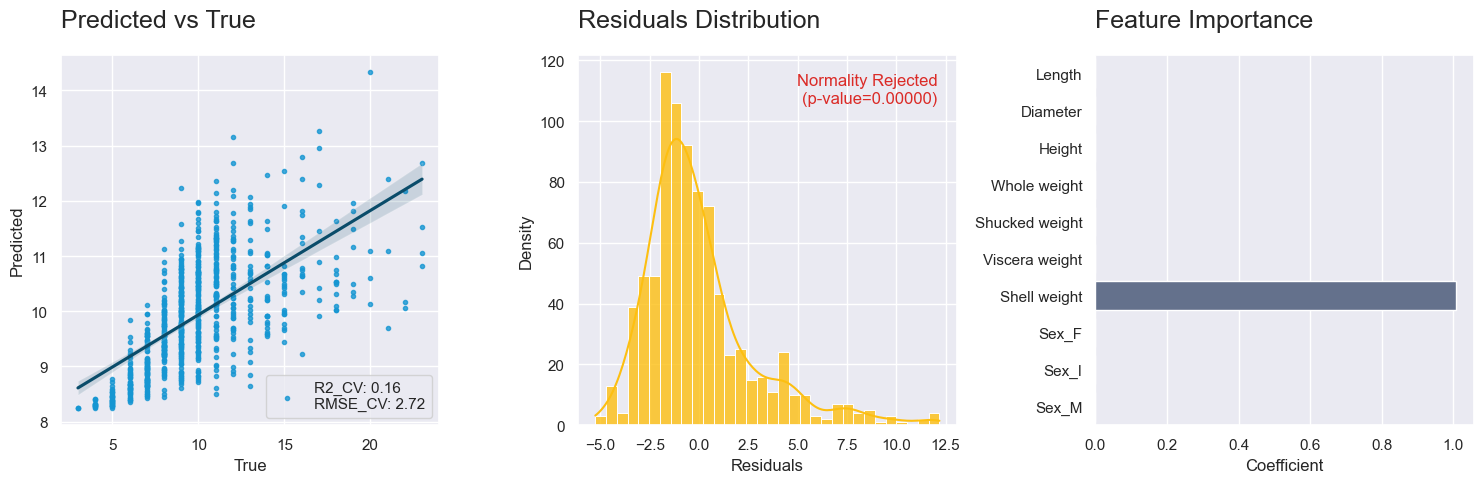

In [11]:
from sklearn.linear_model import Lasso

# Model Pipeline
lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# Fit model
lasso_model.fit(X_train, y_train)

# Predict
y_pred = lasso_model.predict(X_test)

# Display metrics
lasso_metrics = get_metrics(lasso_model, X, y, cv=True)
lasso_feature_importance = get_feature_importance(lasso_model)
print('Lasso Regression metrics:')
display(lasso_metrics)
plot_regression_results(y_test, y_pred,
                        lasso_metrics.loc[['R2_CV', 'RMSE_CV'], 'Test'].values,
                        lasso_feature_importance)

Os resultados indicam que o modelo Lasso não teve um bom desempenho. O coeficiente de determinação (R2) para os dados de treinamento e teste foi de aproximadamente 0,29, o que indica que o modelo só conseguiu explicar cerca de 29% da variância na variável dependente. Além disso, o valor de R2 para a validação cruzada (R2_CV) foi de apenas 0.157, sendo o pior modelo até o momento.

Esses resultados podem ser devido à natureza da regularização Lasso, que tende a encolher alguns dos coeficientes do modelo para zero. Isso pode resultar na eliminação de algumas características de fato importantes para a previsão da variável dependente. Este comportamento é evidenciado pela importância das features, onde muitas delas foram zeradas, sobrando apenas a feature `Shell weight` com coeficiente não nulo.

## 2.4. RIDGE (L2)

A principal diferença entre a regularização Lasso e Ridge é que a Ridge não encolhe os coeficientes para zero. Em vez disso, ela os reduz para valores muito pequenos. Isso significa que, enquanto a regularização Lasso pode eliminar características completamente, a regularização Ridge mantém todas as características, mas reduz a magnitude dos coeficientes para as características menos importantes.  

Ridge Regression metrics:


,Train,Test
MAE,1.577604,1.601396
MSE,4.803719,4.917083
RMSE,2.191739,2.217450
R2,0.532893,0.545775
R2_CV,0.421793,0.421793
RMSE_CV,2.240546,2.240546


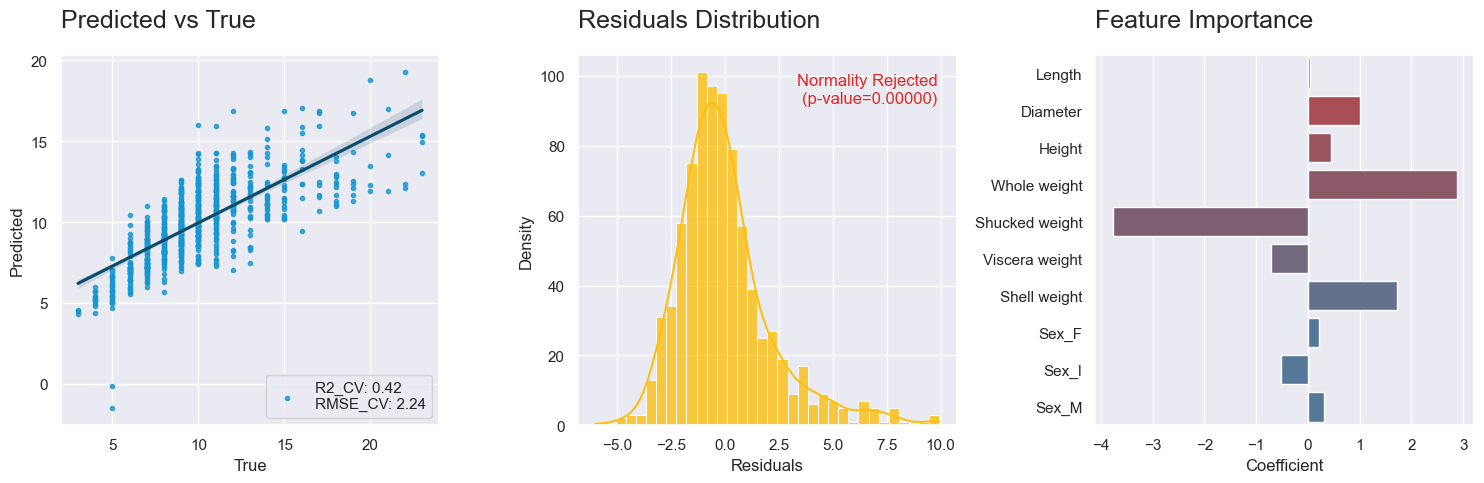

In [12]:
from sklearn.linear_model import Ridge

# Model Pipeline
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=10))
])

# Fit model
ridge_model.fit(X_train, y_train)

# Predict
y_pred = ridge_model.predict(X_test)

# Display metrics
ridge_metrics = get_metrics(ridge_model, X, y, cv=True)
print('Ridge Regression metrics:')
display(ridge_metrics)
ridge_feature_importance = get_feature_importance(ridge_model)
plot_regression_results(y_test, y_pred,
                        ridge_metrics.loc[['R2_CV', 'RMSE_CV'], 'Test'].values,
                        ridge_feature_importance)

A aplicação da regularização RIDGE resultou no melhor modelo até o momento, entretando ainda está bem próximo ao modelo baseline de regressão linear. Com esse resultado, podemos concluir que a regularização L2 foi mais eficaz do que a regularização L1 para este conjunto de dados e, aplicar feature selection não beneficia o modelo.

## 2.5. Otimizando o modelo

O próximo passo em nossa análise é buscar um modelo ainda mais eficaz. Para isso, vamos explorar a escolha do melhor grau para a regressão polinomial e os melhores parâmetros de regularização. A estratégia será utilizar a técnica de busca randomizada de hiper-parâmetros, conhecida como ```GridSearchCV```. Essa técnica permite uma exploração eficiente do espaço de hiper-parâmetros, o que pode nos levar a um modelo de regressão polinomial com desempenho superior e parâmetros de regularização mais adequados para nossos dados.  
Também será utilizado o modelo ```ElasticNet```, que combina as regularizações L1 e L2, e com o hiper-parâmetro ```l1_ratio``` variando de 0 a 1, podemos explorar diferentes combinações de regularizações.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Define grid of hyperparameters
param_grid = {
    'poly__degree': [2, 3, 4],
    'model__alpha': [0.1, 0.5, 1, 5, 10],
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Model Pipeline
elastic_model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('model', ElasticNet())
])

# Grid Search
elastic_search = GridSearchCV(
    elastic_model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit model
elastic_search.fit(X_train, y_train)
best_model = elastic_search.best_estimator_
best_params = elastic_search.best_params_
print('Best parameters:', best_params)

elastic_search

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best parameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.9, 'poly__degree': 3}


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['Sex'], dtype='object'))])),
                                       ('poly', PolynomialFeatures()),
                                       ('model', ElasticNet())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1, 5, 10],
                         'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'poly__degree': [2, 3, 4]},
             scoring='neg_mean_squared_error', verbose=1)

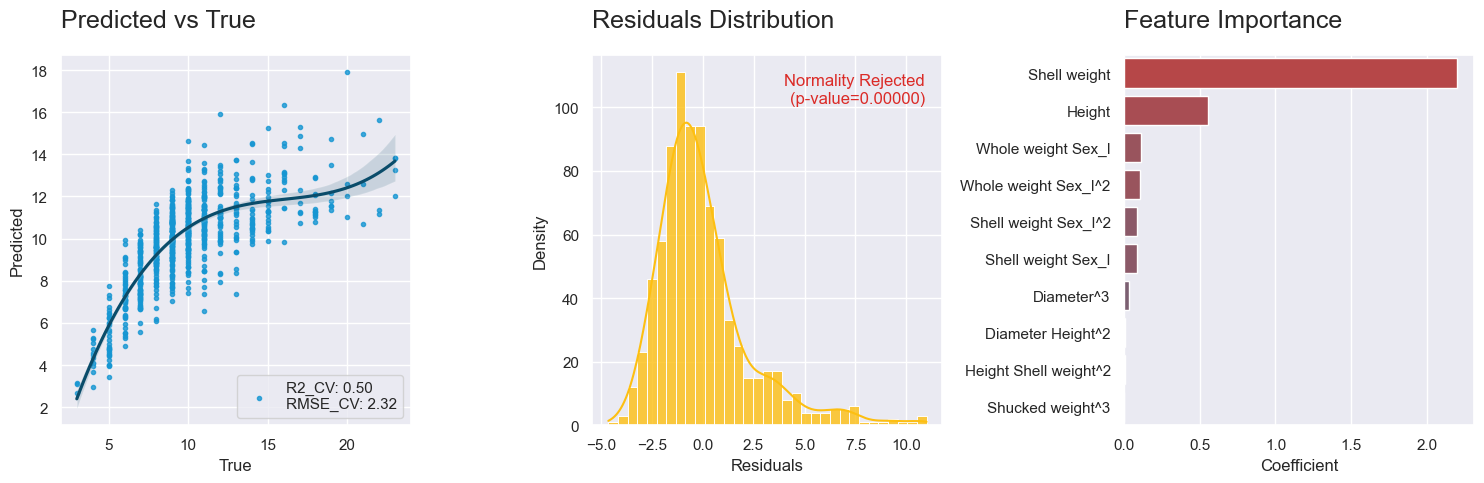

In [14]:
# Predict
y_pred = elastic_search.predict(X_test)

# Display metrics
best_metrics = get_metrics(best_model, X, y, cv=False)  # CV already done in GridSearch
best_feature_importance = get_feature_importance(best_model)
plot_regression_results(y_test, y_pred,
                        best_metrics.loc[['R2', 'RMSE'], 'Test'].values,
                        best_feature_importance.nlargest(10),
                        order=best_params['poly__degree'])

# 3. Conclusões

Model with higher R²-score (avg. CV): ElasticNet (0.50404)
Model with lower RMSE-score (avg. CV): Ridge (2.24055)


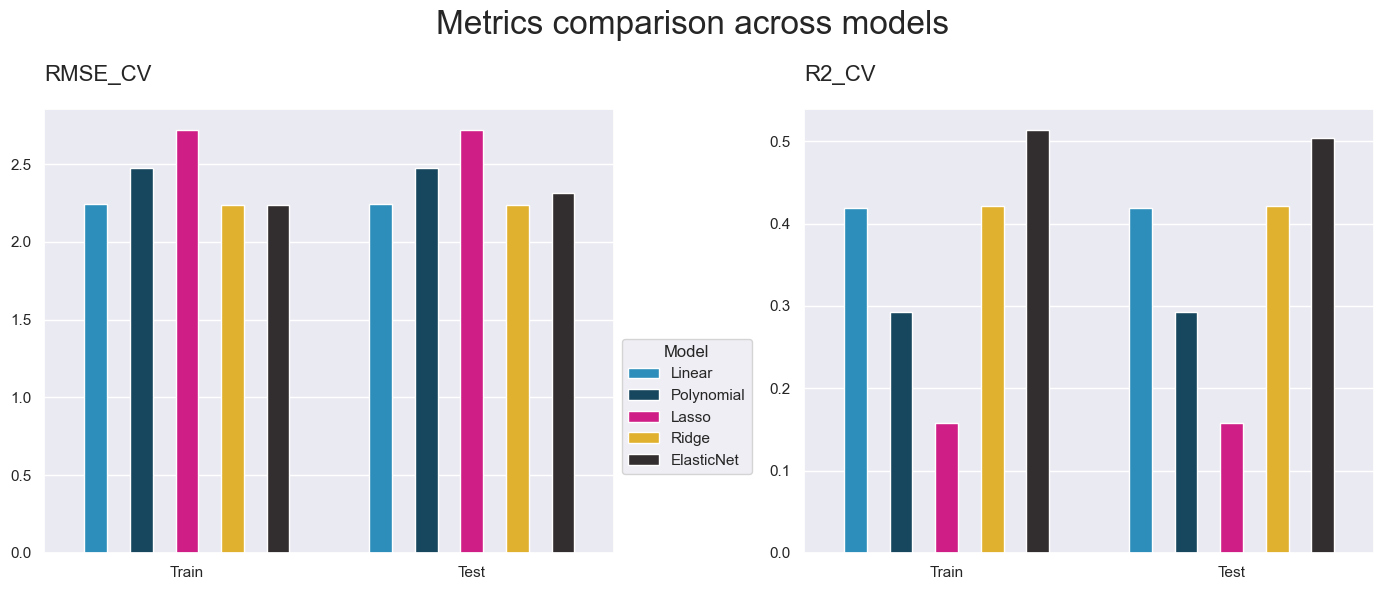

In [23]:
metrics_report(
    model_metrics=[lr_metrics, poly_metrics, lasso_metrics, ridge_metrics, 
                   best_metrics.rename({'RMSE': 'RMSE_CV','R2': 'R2_CV'})],
    model_names=['Linear', 'Polynomial', 'Lasso', 'Ridge', 'ElasticNet'],
    plot_metrics=['RMSE_CV', 'R2_CV'],
    fig_width=14, fig_height=6
)

Em todos os modelos de regressão avaliados, a ocorrência de overfitting foi efetivamente descartada. Esta conclusão é suportada pela proximidade dos valores das métricas de treino e teste, indicando uma boa generalização dos modelos para dados não vistos durante o treinamento. Assim, o desempenho baixo é justamente devido à capacidade limitada dos modelos em capturar a relação entre as características e a variável alvo.     

Entre os modelos avaliados, o que se sobressaiu foi o otimizado com ``ElasticNet``, alcançando um score R2 de 0,51. No entanto, é importante notar que o RMSE deste modelo, que foi de 2,32, acabou sendo superior ao do modelo Ridge, que registrou um RMSE de 2,24. Isso sugere que, apesar do ElasticNet ter apresentado um melhor coeficiente de determinação, o modelo Ridge conseguiu minimizar mais efetivamente o erro nas previsões.   

Portanto, a escolha do modelo ideal pode depender do equilíbrio entre a explicação da variância (R2) e a minimização do erro (RMSE).